# Framework
 - Follow updated ELUT, MLUT, Xoutdata structure
 - From Flux_linkage output-> time_to_freq.py method 
 - flux LUT for idiq  or Make  flux FFT LUT 
 - construct rpm-requency map(Spectrogram)

### Version information

In [3]:
import sys
import matplotlib.pyplot as plt
#sys.path.append(r"C:\Users\LAP10\Documents\Loss\pyleecan")
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print(f'Pyleecan version : {pyleecan.__version__}')
import SciDataTool
print(f'SciDataTool version : {SciDataTool.__version__}')

Running date: June 10, 2022
Pyleecan version : 1.3.8
SciDataTool version : 2.3.10


### Importing of the machine

The machines used in this tutorial will be the Toyota Prius machine.

In [4]:
# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

machine = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

# Simu.Loss (Simu1) First loss Simulation

A first loss simulation on one operating point will be carried out in this section.

### Definition of the simulation

A simulation is defined using the Pyleecan objects.

In [101]:

%matplotlib inline
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.LossFEMM import LossFEMM
from pyleecan.Classes.LossModelSteinmetz import LossModelSteinmetz
from pyleecan.Classes.OutLoss import OutLoss
import numpy as np

from SciDataTool.Functions.Plot.plot_2D import plot_2D 

plt.rcParams['figure.dpi'] = 120

simu = Simu1(name="test_FEMM_Loss_Prius", machine=machine)

Cprox=0

Ic = 230 * np.exp(1j * 140 * np.pi / 180)

simu.input = InputCurrent(
    Nt_tot=40 * 8,
    Na_tot=200 * 8,
    OP=OPdq(N0=1200, Id_ref=Ic.real, Iq_ref=Ic.imag),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    is_get_meshsolution=True,
    is_fast_draw=True,
    is_calc_torque_energy=True,
)

# A loss model is created. is_show_fig is set to True to see the curve-fitting figure, otherwise to False
loss_model = LossModelSteinmetz(is_show_fig=True)
simu.loss = LossFEMM(
    Cp=Cprox,
    is_get_meshsolution=True,
    Tsta=100,
    type_skin_effect=0,
    model_dict={"stator core": loss_model, "rotor core": loss_model},
)

Once set up, the simulation can simply be run using the *run* method.

[04:45:29] Starting running simulation test_FEMM_Loss_Prius (machine=Toyota_Prius)
[04:45:29] Starting Magnetic module
[04:45:30] Solving time steps: 0%
[04:45:30] Solving time steps: 0%
[04:45:31] Solving time steps: 0%
[04:45:31] Solving time steps: 0%
[04:45:33] Solving time steps: 25%
[04:45:33] Solving time steps: 25%
[04:45:33] Solving time steps: 25%
[04:45:33] Solving time steps: 25%
[04:45:35] Solving time steps: 50%
[04:45:35] Solving time steps: 50%
[04:45:35] Solving time steps: 50%
[04:45:35] Solving time steps: 50%
[04:45:37] Solving time steps: 75%
[04:45:37] Solving time steps: 75%
[04:45:38] Solving time steps: 75%
[04:45:38] Solving time steps: 75%
[04:45:39] Solving time step: 100%
[04:45:39] Solving time step: 100%
[04:45:39] Solving time step: 100%
[04:45:39] Solving time step: 100%
[04:45:39] Running LossFEMM module


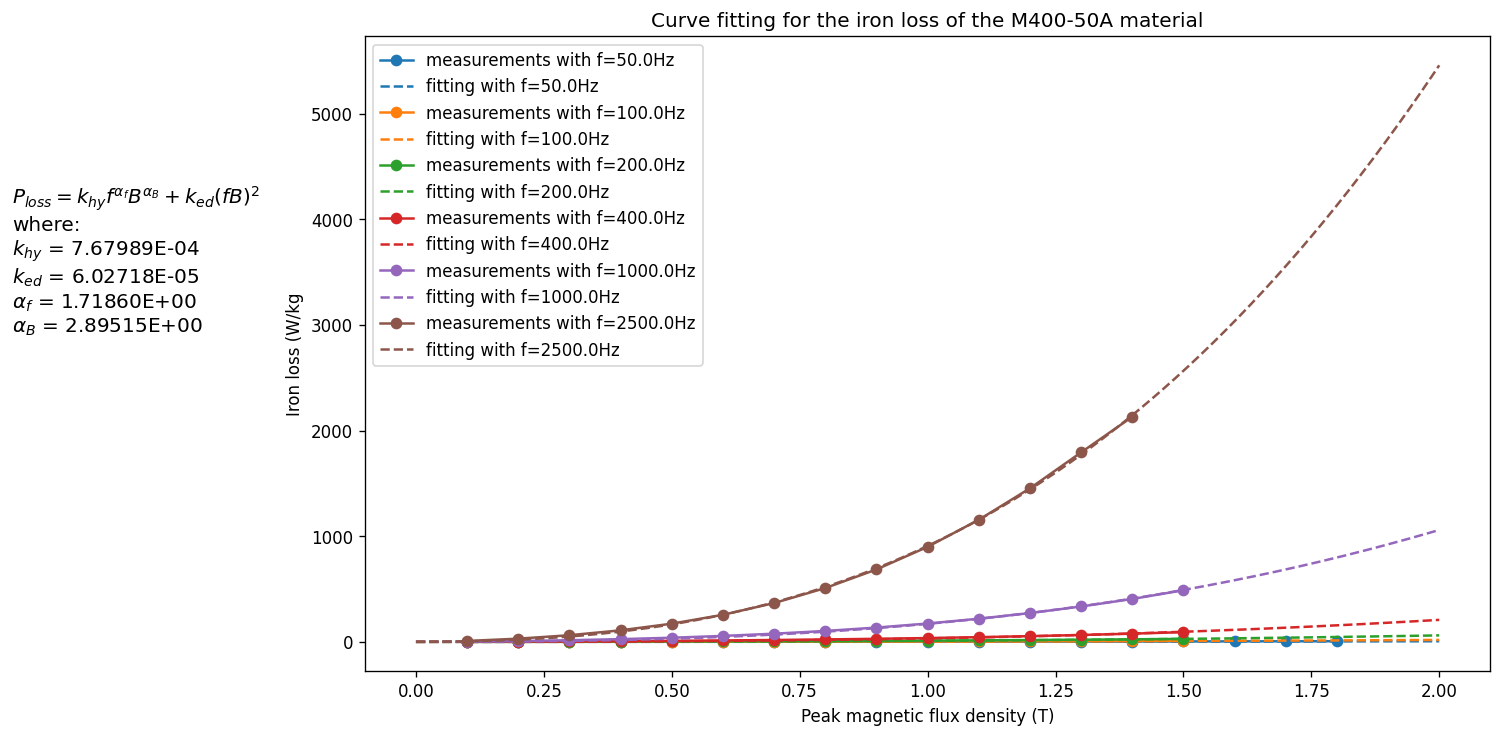

[04:45:41] End of simulation test_FEMM_Loss_Prius


In [102]:
out = simu.run()

Now, the results are stored in the Output object named out. The loss powers can be printed.

In [163]:
power_dict = {
    "total_power": out.mag.Pem_av,
    "overall_losses": out.loss.get_loss_overall(),
    "stator_loss": out.loss.Pstator,
    "copper_loss": out.loss.Pjoule,
    "rotor_loss": out.loss.Protor,
    "magnet_loss": out.loss.Pmagnet,
    "proximity_loss": out.loss.Pprox,
    "efficiency": out.loss.efficiency
}
print(power_dict)

{'total_power': 54582.82393145293, 'overall_losses': 7818.753785218238, 'stator_loss': 292.64231427566983, 'copper_loss': 7499.124524961877, 'rotor_loss': 14.808162839541831, 'magnet_loss': 12.17878314114945, 'proximity_loss': 0, 'efficiency': 0.8567543189953435}


### Plotting the distribution of the losses in the machine

The meshsolution is stored in the output of the ismulation, allowing to plot the machine with the loss values in each elements.

In [164]:
out.loss.meshsol_list[0].plot_contour(
    "freqs=sum",
    label="Loss",
    group_names=[
        "stator core",
        # "stator winding",
        "rotor core",
        "rotor magnets",
    ],
    # clim=[2e4, 2e7],
)

## 회전 속도에 대한 손실 플롯 -> flux linkage fft 차수 플롯

lossFEMM 객체는 첫 번째 시뮬레이션에서 계산된 계수를 저장합니다. 이러한 계수를 사용하면 다른 시뮬레이션을 수행하지 않고도 기계의 회전 속도에 대한 손실을 플롯할 수 있습니다.


C:\Users\KDH2018-PC\anaconda3\envs\py38_pcan138_SDT_2310\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:482: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


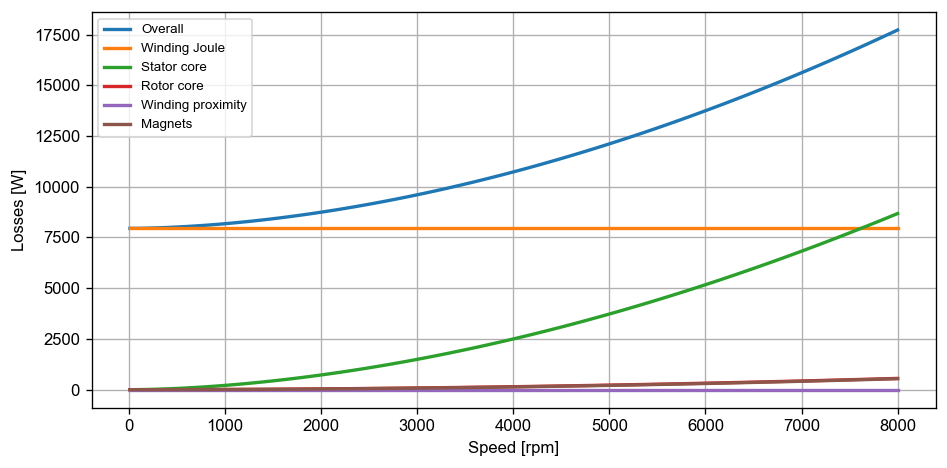

In [165]:
speed_array = np.linspace(10, 8000, 100)
p = machine.get_pole_pair_number()
outloss_list = list()
OP = out.elec.OP.copy()
for speed in speed_array:
    OP.felec = speed / 60 * p
    out_dict = {"coeff_dict": out.loss.coeff_dict}
    outloss = OutLoss()
    outloss.store(out_dict, lam=machine.stator, OP=OP, type_skin_effect=0, Tsta=120, Pem=out.mag.Pem_av)
    outloss_list.append(outloss)
joule_list = [o.Pjoule for o in outloss_list]
sc_list = [o.Pstator for o in outloss_list]
rc_list = [o.Protor for o in outloss_list]
prox_list = [o.Pprox for o in outloss_list]
mag_list = [o.Pmagnet for o in outloss_list]
ovl_list = [o.get_loss_overall() for o in outloss_list]
eff_list = [o.efficiency for o in outloss_list]
plot_2D(
[speed_array],
[ovl_list, joule_list, sc_list, rc_list, prox_list, mag_list],
xlabel="Speed [rpm]",
ylabel="Losses [W]",
legend_list=[
    "Overall",
    "Winding Joule",
    "Stator core",
    "Rotor core",
    "Winding proximity",
    "Magnets",
])

# Flux Linkage IdIq 맵만들기 OP_matrix & VarLoadCurrent 
다음 단계는 *VarLoadCurrent*가 있는 *var_simu* 속성을 포함하는 시뮬레이션을 정의하는 것입니다. *VarLoadCurrent* 개체는 여러 시뮬레이션을 수행하기 위해 여러 작동 지점을 정의하기 위해 *OP_matrix*가 필요합니다. *OP_matrix*는 다음 수량을 나타내는 3개의 열이 있는 행렬입니다.
1. 회전 속도
2. $I_d$
3. $I_q$


In [8]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange, sqrt, exp,pi
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq


simu = Simu1(name="Varload", machine=machine)


# #(operating point - 전류 직접 넣을때(속도 토크 x) opdq()

I0_rms = 250/sqrt(2) # Maximum current [Arms]
Phi0 = 140*pi/180  # Maximum Torque Per Amp
Id_ref = (I0_rms*exp(1j*Phi0)).real # [Arms] 
Iq_ref = (I0_rms*exp(1j*Phi0)).imag # [Arms] 



#NU Inputcurrent로 OPdq로 전류넣기
simu.input = InputCurrent(
    Nt_tot=40 * 8,
    Na_tot=200 * 8,
    OP=OPdq(N0=1200, Id_ref=Id_ref, Iq_ref=Iq_ref),
    is_periodicity_t=True,
    is_periodicity_a=True,
)

simu.mag = MagFEMM(
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=4,
    is_get_meshsolution=True,
    is_fast_draw=True,
)

## OP_matrix 만들기

### 직접 OP_matrix 만들기 (전류원 하나)


In [9]:
Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_simu = Tem_av_ref.size  #13개

OP_matrix = zeros((N_simu,4)) # 13개
OP_matrix[:, 0] = np.linspace(500, 8000, N_simu) #속도
OP_matrix[:,1] = I0_rms * ones((N_simu))   #전류
OP_matrix[:,2] = Phi0_ref #위상각
OP_matrix[:,3] = Tem_av_ref #토크
print('number of simulation:',N_simu)
print(OP_matrix)


number of simulation: 13
[[5.00000000e+02 1.76776695e+02 1.04719755e+00 7.90000000e+01]
 [1.12500000e+03 1.76776695e+02 1.22173048e+00 1.25000000e+02]
 [1.75000000e+03 1.76776695e+02 1.39626340e+00 1.60000000e+02]
 [2.37500000e+03 1.76776695e+02 1.57079633e+00 1.92000000e+02]
 [3.00000000e+03 1.76776695e+02 1.74532925e+00 2.37000000e+02]
 [3.62500000e+03 1.76776695e+02 1.91986218e+00 2.81000000e+02]
 [4.25000000e+03 1.76776695e+02 2.09439510e+00 3.19000000e+02]
 [4.87500000e+03 1.76776695e+02 2.26892803e+00 3.43000000e+02]
 [5.50000000e+03 1.76776695e+02 2.44346095e+00 3.53000000e+02]
 [6.12500000e+03 1.76776695e+02 2.61799388e+00 3.32000000e+02]
 [6.75000000e+03 1.76776695e+02 2.79252680e+00 2.66000000e+02]
 [7.37500000e+03 1.76776695e+02 2.96705973e+00 1.64000000e+02]
 [8.00000000e+03 1.76776695e+02 3.14159265e+00 2.20000000e+01]]


### 직접 OP_matrix만들기 (전류 meshgrid)

In [10]:
# Build OP_matrix with a meshgrid of Id/Iq
n_Id=5
n_Iq=5
Id_min, Id_max = -230, 230
Iq_min, Iq_max = -230, 230
Id, Iq = np.meshgrid(
np.linspace(Id_min, Id_max, n_Id), np.linspace(Iq_min, Iq_max, n_Iq)
)

## OPMatrix 만들기
OP_matrix = np.zeros((n_Id * n_Iq, 3))
OP_matrix[:, 0] = simu.input.OP.N0
OP_matrix[:, 1] = Id.ravel() #ravel() 다차원 배열 1차원 변환 함수
OP_matrix[:, 2] = Iq.ravel()

### LUT.h5로 OP_matrix만들기 (idiq 맵)

  


모든 시뮬레이션 동안 더 빠른 계산을 허용하려면 먼저 룩업 테이블이 필요합니다. 이 LUT는 현재 $I_d$ 및 $I_q$에 대해 여러 수량을 저장합니다.

LUT를 저장할 수 있으므로 scipt가 실행될 때마다 계산되지 않습니다. 이것이 처음이고 LUT가 존재하지 않으면 None으로 설정되고 다른 시뮬레이션을 실행하기 전에 계산됩니다.

#### LUT 불러오기 Defining a Look up table (LUT) from h5 file - Id_LUT Iq_LUT       

In [ ]:
from os.path import exists, split

path_to_LUT = r"Z:\01_Codes_Projects\git_pyleecan_public\pyleecan\Tutorials\LUT.h5"

if not exists(split(path_to_LUT)[0]):
    raise Exception("The path to LUT is not valid.")
try:
    LUT_enforced = load(path_to_LUT)
    is_LUT_exists = True
except FileNotFoundError:
    print("The LUT could not be loaded, so it will be computed.")
    LUT_enforced = None
    is_LUT_exists = False


idiq=LUT_enforced.get_OP_matrix()
# print(LUT_enforced.xoutput_dict)
Id_LUT=idiq[:,1]
Iq_LUT=idiq[:,2]
print(Id_LUT)    


#### LUT idiq 출력하기

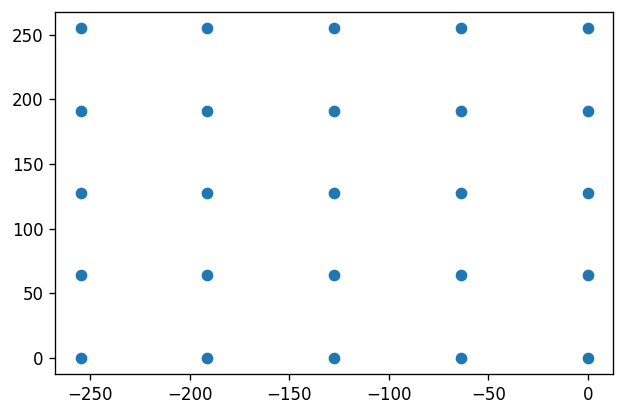

In [370]:
plt.scatter(Id_LUT,Iq_LUT)

#### LUT.h5 OP_matrix 만들기

In [371]:
N_simu_h5=Id_LUT.size
OP_matrix = zeros((N_simu_h5,3)) # 13개
OP_matrix[:, 0] =idiq[:,0]
OP_matrix[:,1] = Id_LUT  #전류
OP_matrix[:,2] = Iq_LUT #위상각

print('number of simulation:',N_simu_h5)
print(OP_matrix)


number of simulation: 25
[[ 500.         -254.76758191    0.        ]
 [ 500.         -191.07568643    0.        ]
 [ 500.         -127.38379095    0.        ]
 [ 500.          -63.69189548    0.        ]
 [ 500.            0.            0.        ]
 [ 500.         -254.76758191   63.69189548]
 [ 500.         -191.07568643   63.69189548]
 [ 500.         -127.38379095   63.69189548]
 [ 500.          -63.69189548   63.69189548]
 [ 500.            0.           63.69189548]
 [ 500.         -254.76758191  127.38379095]
 [ 500.         -191.07568643  127.38379095]
 [ 500.         -127.38379095  127.38379095]
 [ 500.          -63.69189548  127.38379095]
 [ 500.            0.          127.38379095]
 [ 500.         -254.76758191  191.07568643]
 [ 500.         -191.07568643  191.07568643]
 [ 500.         -127.38379095  191.07568643]
 [ 500.          -63.69189548  191.07568643]
 [ 500.            0.          191.07568643]
 [ 500.         -254.76758191  254.76758191]
 [ 500.         -191.07568643 

## VarLoad Current로 var_simu에 OP매트릭스 입력

In [11]:
simu.var_simu = VarLoadCurrent(
    OP_matrix=OP_matrix, type_OP_matrix=1, is_keep_all_output=True,
)
simu.var_simu.is_reuse_femm_file=True  

##simu_copy
simu_vop = simu.copy()

### Var_simu 실행

In [16]:
from pyleecan.Classes.PostLUT import PostLUT
simu_vop.var_simu.postproc_list=[PostLUT(is_save_LUT=True)]

In [17]:
from pyleecan.Classes.ElecLUTdq import ElecLUTdq

# Speed-up computation (set reference simu as first OP)
# simu_vop.input.set_OP_from_array(varload.OP_matrix, varload.type_OP_matrix)
simu_vop.input.set_OP_from_array(OP_matrix, type_OP_matrix=0)




Xout = simu_vop.run()
# ELUT = Xout.simu.var_simu.postproc_list[0].LUT

[04:12:04] Starting running simulation Varload (machine=Toyota_Prius)
[04:12:04] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[04:12:04] Computing reference simulation for Variable Load
[04:12:04] Starting Magnetic module
[04:12:05] Solving time steps: 0%
[04:12:05] Solving time steps: 0%
[04:12:05] Solving time steps: 0%
[04:12:05] Solving time steps: 0%
[04:12:07] Solving time steps: 25%
[04:12:07] Solving time steps: 25%
[04:12:07] Solving time steps: 25%
[04:12:08] Solving time steps: 25%
[04:12:09] Solving time steps: 50%
[04:12:09] Solving time steps: 50%
[04:12:09] Solving time steps: 50%
[04:12:10] Solving time steps: 50%
[04:12:12] Solving time steps: 75%
[04:12:12] Solving time steps: 75%
[04:12:12] Solving time steps: 75%
[04:12:13] Solving time steps: 75%
[04:12:13] Solving time step: 100%
[04:12:14] Solving time step: 100%
[04:12:14] Solving time step: 100%
[04:12:14] Solving time step: 100%
[04:12:14] Variable Load Reference Results

## Xoutput 출력

Pyleecan은 각 시뮬레이션에서 일부 값을 자동으로 추출합니다. 이 값은 모두 xoutput_dict에 수집됩니다.

In [113]:
# Xout.xoutput_dict.keys()
# print(Xout.xoutput_dict.get('Id'))
dir(Xout.simu.var_simu)
dir(Xout.simu.elec)
a=Xout.simu.var_simu.get_mag_datakeeper('sybol_list')

In [24]:
Xout.mag.Phi_wind_stator.plot_2D_Data('time')

AttributeError: 'NoneType' object has no attribute 'Phi_wind_stator'

## 핵심 - 한속도로부터 모든 속도에 대한 고조파 차수 맵 만들기

In [ ]:
# post_processing에 대한 관련 데이터를 포함하는 여러 행렬이 생성됩니다.
OP_matrix_MTPA = np.zeros((Nspeed, Nload, 5))
U_MTPA = np.zeros((Nspeed, Nload, 3))
I_MTPA = np.zeros((Nspeed, Nload, 3))
Phidq_MTPA = np.zeros((Nspeed, Nload, 2))


In [ ]:
#출력은 xoutput으로 나올꺼임
# np.shape(OP_matrix[:,1]* np.exp(1j *OP_matrix[:,2]* np.pi / 180).imag)
# np.shape(OP_matrix[:,1]* np.exp(1j *OP_matrix[:,2]* np.pi / 180).real)
# OP_matrix[:,2]
Phi0 = 140*pi/180
print(Phi0)



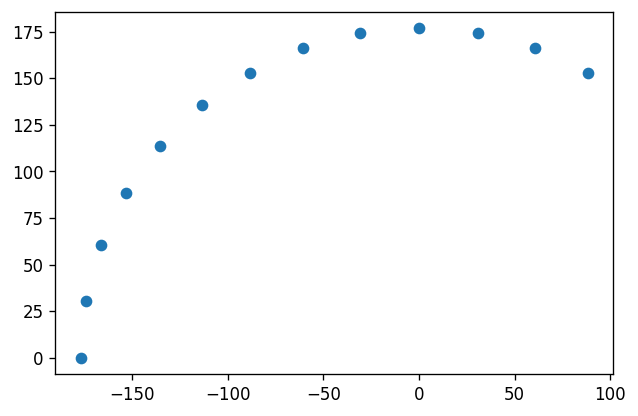

In [339]:
import matplotlib.pyplot as plt


dict_map = {
    
    "Xdata":  OP_matrix[:,1]* np.exp(1j *OP_matrix[:,2]).real,  # Id
    "Ydata": OP_matrix[:,1]* np.exp(1j *OP_matrix[:,2]).imag,  # Iq
    "xlabel": "d-axis current [Arms]",
    "ylabel": "q-axis current [Arms]",
    "type_plot": "pcolormesh",
    "is_contour": True,
}
# # OP_matrix_MTPA[:, :, 3]=

id_p=OP_matrix[:,1]* np.exp(1j *OP_matrix[:,2]).real
iq_p=OP_matrix[:,1]* np.exp(1j *OP_matrix[:,2]).imag
plt.scatter(id_p,iq_p)              


# # Plot torque maps
# plot_3D(
# #     Zdata=OP_matrix_MTPA[:, :, 3],
# #     zlabel="Average Torque [N.m]",
#     title="Torque map in dq plane",
#     **dict_map,
# )

In [255]:
print(simu.var_simu)
# print(simu.input.set_OP_from_array)
# simu.input.OP
# print(out.mag.B)

None


# 시뮬레이션의 전기 모듈은 이전에 정의된 LUT를 고려하기 위해 ElecLUTdq 객체여야 합니다.

In [143]:
from pyleecan.Classes.ElecLUTdq import ElecLUTdq
from pyleecan.Classes.PostLUT import PostLUT

# Definition of a loss model
loss_model = LossModelSteinmetz()

simu.elec = ElecLUTdq(
    Urms_max=400,
    Jrms_max=30e6,
    n_interp=100,
    n_Id=5,
    n_Iq=5,
    Id_max=0,
    Iq_min=0,
    LUT_enforced=LUT_enforced,
    is_grid_dq=True,
    LUT_simu=Simu1(
        input=InputCurrent(
            OP=OPdq(),
            Nt_tot=4 * 8,
            Na_tot=200 * 8,
            is_periodicity_a=True,
            is_periodicity_t=True,
        ),
        var_simu=VarLoadCurrent(
            type_OP_matrix=1,
            postproc_list=[PostLUT(is_save_LUT=False)],
            is_keep_all_output=True,
        ),
        mag=MagFEMM(
            is_periodicity_a=True,
            is_periodicity_t=True,
            nb_worker=4,
            is_get_meshsolution=True,
        ),
        loss=LossFEMM(
            Cp=1,
            is_get_meshsolution=True,
            Tsta=100,
            type_skin_effect=1,
            model_dict={"stator core": loss_model, "rotor core": loss_model},
        )
    ),
)

## 핵심 
Now comes the core of the algorithms. For several values of load rates (defining the required torque), a simlation will be run for every values of speed in the *OP_matrix*. The simulations will be very fast as the magnetic and loss quantities are interpolated from the LUT previously computed.

이제 알고리즘의 핵심이 나옵니다. 부하율의 여러 값(필요한 토크 정의)에 대해 *OP_matrix*의 모든 속도 값에 대해 시뮬레이션이 실행됩니다. 자기 및 손실 양이 이전에 계산된 LUT에서 보간되기 때문에 시뮬레이션은 매우 빠릅니다.

In [144]:
# Nload 시뮬레이션은 0.1과 1 사이의 부하 값으로 수행됩니다.
Nload = 3
load_vect = np.linspace(0.1, 1, Nload)

# post_processing에 대한 관련 데이터를 포함하는 여러 행렬이 생성됩니다.
OP_matrix_MTPA = np.zeros((Nspeed, Nload, 5))
U_MTPA = np.zeros((Nspeed, Nload, 3))
I_MTPA = np.zeros((Nspeed, Nload, 3))
Phidq_MTPA = np.zeros((Nspeed, Nload, 2))

# 계산될 Nload 출력을 포함하도록 출력 목록이 생성됩니다.
out_load = list()

for ii, load_rate in enumerate(load_vect):
    # Re using the LUT computed during the first step
    if ii > 0 and LUT_enforced is None:
        simu.elec.LUT_enforced = out.output_list[0].simu.elec.LUT_enforced

    simu.elec.load_rate = load_rate

    out = simu.run()

    # Store values in MTPA, the five columns of the OP_matrix_MTPA will be filled
    # First column is rotational speed
    OP_matrix_MTPA[:, ii, 0] = out["N0"].result
    # Second columns is Id
    OP_matrix_MTPA[:, ii, 1] = out["Id"].result
    # Third column is Iq
    OP_matrix_MTPA[:, ii, 2] = out["Iq"].result
    # Fourth column is the average torque
    OP_matrix_MTPA[:, ii, 3] = [out_ii.elec.Tem_av for out_ii in out.output_list]
    # Fifth column is the efficiency
    OP_matrix_MTPA[:, ii, 4] = [out_ii.elec.OP.efficiency for out_ii in out.output_list]
    
    # Store the voltages and currents in two dedicated matrixes
    # First column is Ud
    U_MTPA[:, ii, 0] = [out_ii.elec.OP.Ud_ref for out_ii in out.output_list]
    # Second column is Uq
    U_MTPA[:, ii, 1] = [out_ii.elec.OP.Uq_ref for out_ii in out.output_list]
    # Third column is U0
    U_MTPA[:, ii, 2] = [
        out_ii.elec.OP.get_U0_UPhi0()["U0"] for out_ii in out.output_list
    ]
    # First column is Id
    I_MTPA[:, ii, 0] = OP_matrix_MTPA[:, ii, 1]
    # Second column is Iq
    I_MTPA[:, ii, 1] = OP_matrix_MTPA[:, ii, 2]
    # Third column is I0
    I_MTPA[:, ii, 2] = [
        out_ii.elec.OP.get_I0_Phi0()["I0"] for out_ii in out.output_list
    ]
    # The fluxes are also stored in their dedicated matrix
    # First column is phid
    Phidq_MTPA[:, ii, 0] = [out_ii.elec.eec.Phid for out_ii in out.output_list]
    # second column is phiq
    Phidq_MTPA[:, ii, 1] = [out_ii.elec.eec.Phiq for out_ii in out.output_list]
    # The output of the current simulation is appended to the list of outputs
    out_load.append(out)

[00:45:11] Starting running simulation test_ElecLUTdq_efficiency_map (machine=Toyota_Prius)
[00:45:11] Computing reference simulation for Variable Load
[00:45:11] Starting Electrical module
[00:45:11] Variable Load Reference Results: N0=500 [rpm], Id=-2.92e-07 [Arms], Iq=20.8 [Arms]
[                                                  ]   1%
[00:45:11] Variable Load: Using same LUT for all simulations
[00:45:11] Running simulation 1/50 with N0=500 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:11] Simulation matches reference one: Skipping computation
[00:45:11] Variable Load Results: N0=500 [rpm], Id=-2.92e-07 [Arms], Iq=20.8 [Arms]
[=                                                 ]   3%
[00:45:11] Running simulation 2/50 with N0=653.061 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:11] Starting Electrical module
[00:45:11] Variable Load Results: N0=653.1 [rpm], Id=-2.92e-07 [Arms], Iq=20.8 [Arms]
[==                                                ]   5%
[00:45:11] Running simulation 3/50 with N0=80

[00:45:14] Variable Load Results: N0=4939 [rpm], Id=-1.192e-07 [Arms], Iq=15.6 [Arms]
[==============================                    ]  60%
[00:45:14] Running simulation 31/50 with N0=5091.84 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:14] Starting Electrical module
[00:45:14] Variable Load Results: N0=5092 [rpm], Id=-10.4 [Arms], Iq=15.6 [Arms]
[===============================                   ]  62%
[00:45:14] Running simulation 32/50 with N0=5244.9 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:14] Starting Electrical module
[00:45:14] Variable Load Results: N0=5245 [rpm], Id=-5.199 [Arms], Iq=10.4 [Arms]
[================================                  ]  64%
[00:45:14] Running simulation 33/50 with N0=5397.96 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:14] Starting Electrical module
[00:45:15] Variable Load Results: N0=5398 [rpm], Id=-1.46e-07 [Arms], Iq=10.4 [Arms]
[=================================                 ]  66%
[00:45:15] Running simulation 34/50 with N0=5551.02 [rpm], Id=0 [Arms

[00:45:18] Starting Electrical module
[00:45:18] Variable Load Results: N0=1878 [rpm], Id=-72.79 [Arms], Iq=88.39 [Arms]
[==========                                        ]  21%
[00:45:18] Running simulation 11/50 with N0=2030.61 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:18] Starting Electrical module
[00:45:18] Variable Load Results: N0=2031 [rpm], Id=-72.79 [Arms], Iq=88.39 [Arms]
[===========                                       ]  23%
[00:45:18] Running simulation 12/50 with N0=2183.67 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:18] Starting Electrical module
[00:45:18] Variable Load Results: N0=2184 [rpm], Id=-72.79 [Arms], Iq=88.39 [Arms]
[============                                      ]  25%
[00:45:18] Running simulation 13/50 with N0=2336.73 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:18] Starting Electrical module
[00:45:18] Variable Load Results: N0=2337 [rpm], Id=-72.79 [Arms], Iq=88.39 [Arms]
[=============                                     ]  27%
[00:45:18] Running simulation 14

[=========================================         ]  82%
[00:45:21] Running simulation 42/50 with N0=6775.51 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:21] Starting Electrical module
[00:45:21] Variable Load Results: N0=6776 [rpm], Id=-62.39 [Arms], Iq=36.4 [Arms]
[==========================================        ]  84%
[00:45:21] Running simulation 43/50 with N0=6928.57 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:22] Starting Electrical module
[00:45:22] Variable Load Results: N0=6929 [rpm], Id=-62.39 [Arms], Iq=31.2 [Arms]
[===========================================       ]  86%
[00:45:22] Running simulation 44/50 with N0=7081.63 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:22] Starting Electrical module
[00:45:22] Variable Load Results: N0=7082 [rpm], Id=-51.99 [Arms], Iq=31.2 [Arms]
[============================================      ]  88%
[00:45:22] Running simulation 45/50 with N0=7234.69 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:22] Starting Electrical module
[00:45:22] Variable Load Results: 

[00:45:23] Variable Load Results: N0=3561 [rpm], Id=-191 [Arms], Iq=168.6 [Arms]
[=====================                             ]  43%
[00:45:23] Running simulation 22/50 with N0=3714.29 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:23] Starting Electrical module
[00:45:23] Variable Load Results: N0=3714 [rpm], Id=-203.1 [Arms], Iq=153.8 [Arms]
[======================                            ]  45%
[00:45:23] Running simulation 23/50 with N0=3867.35 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:23] Starting Electrical module
[00:45:23] Variable Load Results: N0=3867 [rpm], Id=-220.2 [Arms], Iq=127.2 [Arms]
[=======================                           ]  47%
[00:45:23] Running simulation 24/50 with N0=4020.41 [rpm], Id=0 [Arms], Iq=0 [Arms]
[00:45:23] Starting Electrical module
[00:45:23] Variable Load Results: N0=4020 [rpm], Id=-226.4 [Arms], Iq=116.8 [Arms]
[========================                          ]  49%
[00:45:23] Running simulation 25/50 with N0=4173.47 [rpm], Id=0 [Arms], 

결국 LUT가 존재하지 않고 계산된 경우 LUT를 저장할 수 있습니다.

In [156]:
# print(out.elec.eec)
print(simu.var_simu.datakeeper_list[0])

parent = <class 'pyleecan.Classes.VarLoadCurrent.VarLoadCurrent'> object
name = "Speed"
symbol = "N0"
unit = "rpm"
keeper = lambda output: output.elec.OP.get_N0()
error_keeper = None

result = 
[]
result_ref = None

physic = "None"



In [145]:
if not is_LUT_exists:
    simu.elec.LUT_enforced.save(save_path=path_to_LUT)

## Plots

We need to import plots functions from SciDataTool.

In [23]:
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from SciDataTool.Functions.Plot.plot_3D import plot_3D
#Set the resolution of the figure to make them bigger
plt.rcParams['figure.dpi'] = 150

Now we can simply plot the eficiency map using this code.

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000018E7DE11C70>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000018E7DE11C70> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


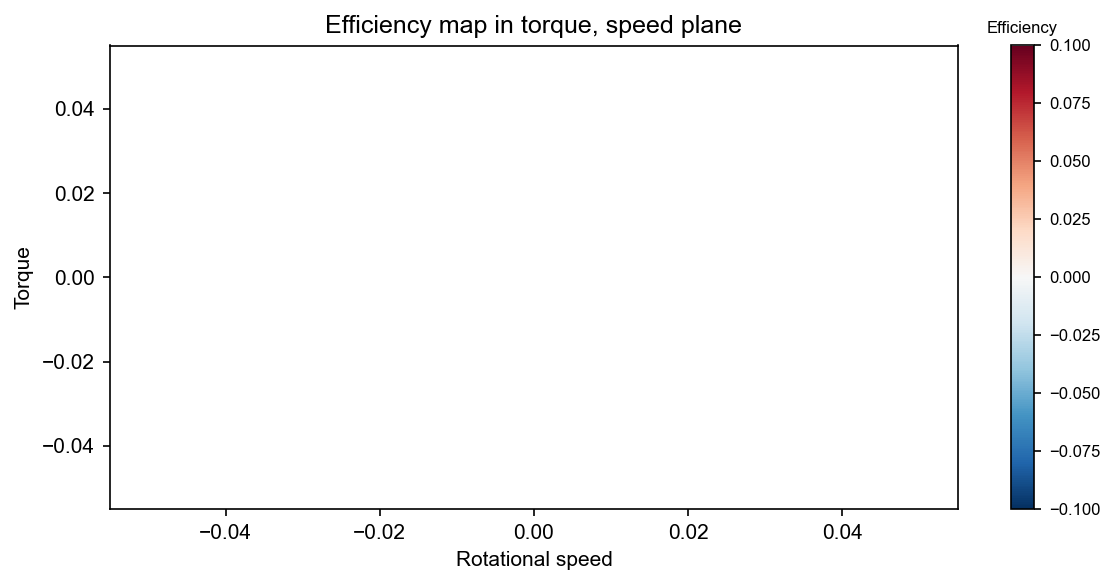

In [25]:
#init plot map for efficiency
dict_eff_map = {
    "Xdata": OP_matrix_MTPA[:, :, 0],  # Rotational speed
    "Ydata": OP_matrix_MTPA[:, :, 3],  # Torque
    "xlabel": "Rotational speed",
    "ylabel": "Torque",
    "type_plot": "pcolormesh",
    "is_contour": True,
}

plot_3D(
    Zdata=OP_matrix_MTPA[:, :, 4],
    zlabel="Efficiency",
    title="Efficiency map in torque, speed plane",
    **dict_eff_map,
)

Also, the losses can be plotted as a function of $I_d$/$I_q$ thanks to the look up table.

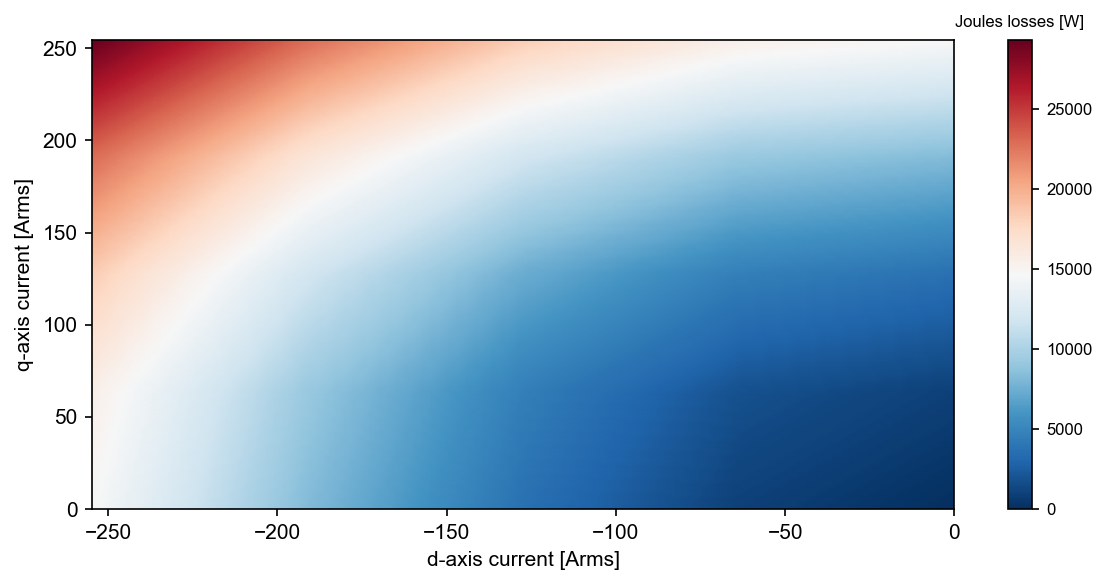

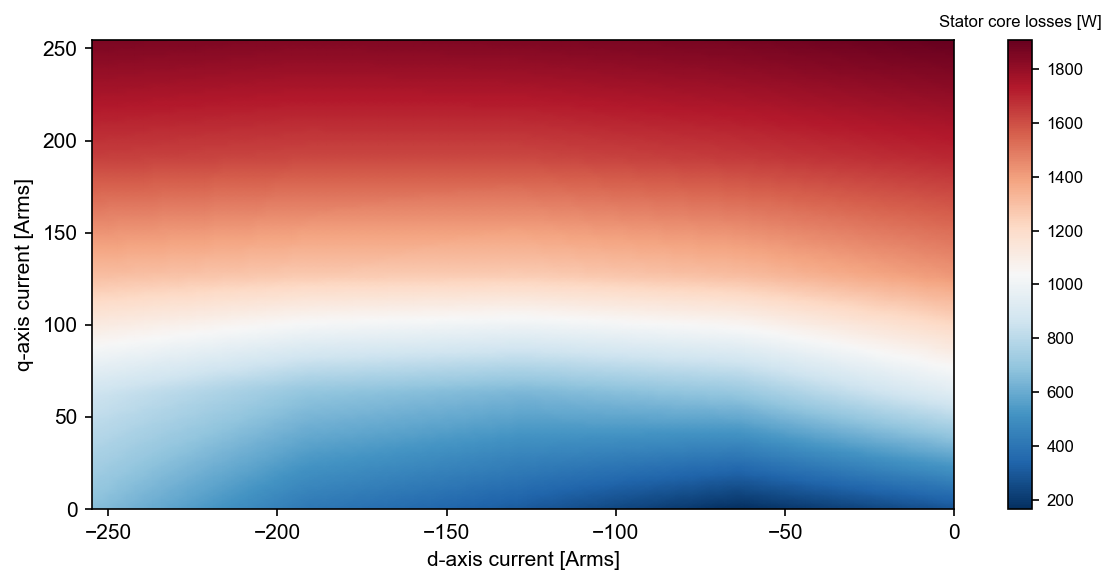

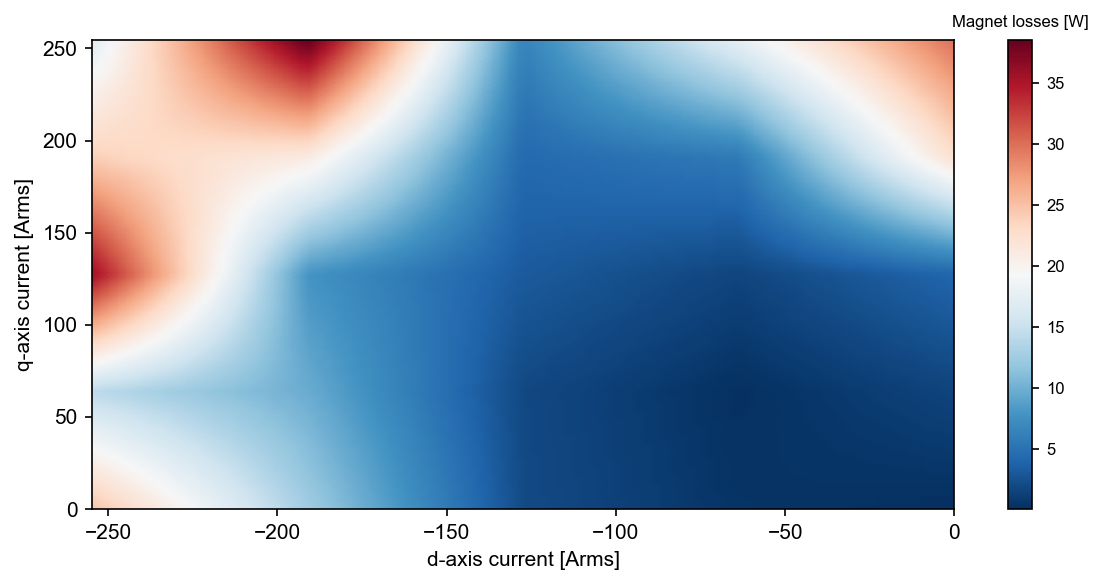

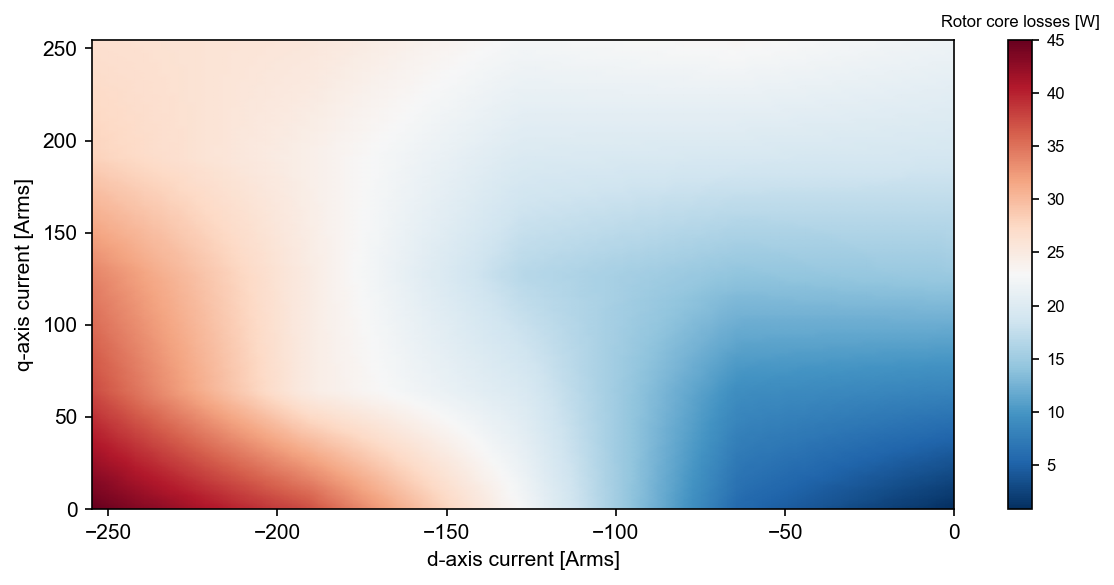

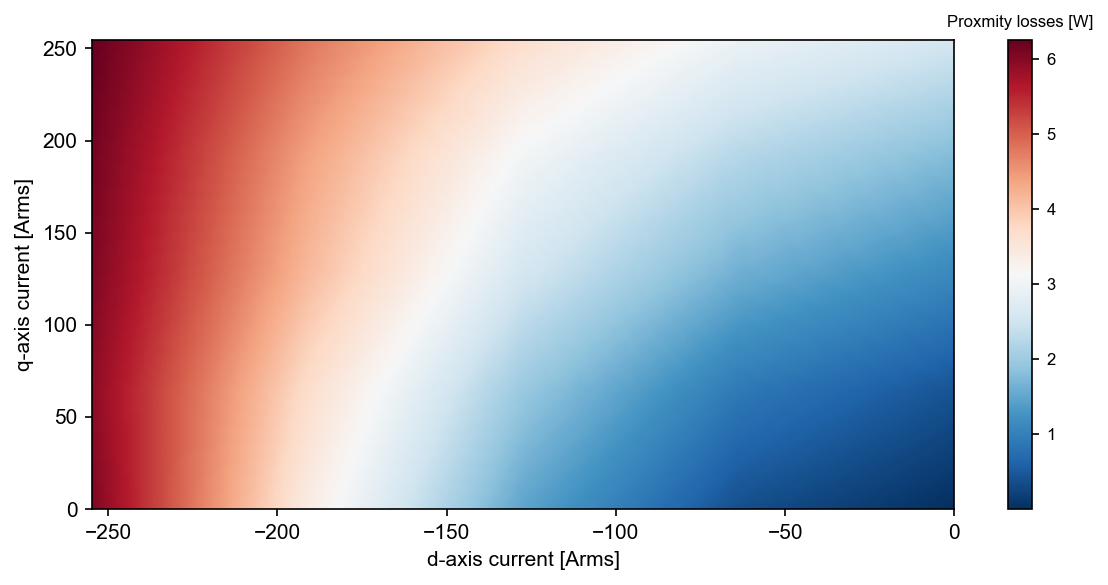

In [26]:
LUT_grid = out.simu.elec.LUT_enforced

# Get Id_min, Id_max, Iq_min, Iq_max from OP_matrix
OP_matrix = LUT_grid.get_OP_matrix()
Id_min = OP_matrix[:, 1].min()
Id_max = OP_matrix[:, 1].max()
Iq_min = OP_matrix[:, 2].min()
Iq_max = OP_matrix[:, 2].max()

nd, nq = 100, 100
Id_vect = np.linspace(Id_min, Id_max, nd)
Iq_vect = np.linspace(Iq_min, Iq_max, nq)
Id, Iq = np.meshgrid(Id_vect, Iq_vect)
Id, Iq = Id.ravel(), Iq.ravel()

# Interpolate Phid/Phiq on the refined mesh

Ploss_dqh = LUT_grid.interp_Ploss_dqh(Id, Iq, N0=3000)
dict_map = {
    "Xdata": Id.reshape((nd, nq))[0, :],
    "Ydata": Iq.reshape((nd, nq))[:, 0],
    "xlabel": "d-axis current [Arms]",
    "ylabel": "q-axis current [Arms]",
    "type_plot": "pcolormesh",
    "is_contour": True,
}
loss_list = ["Joules losses",
            "Stator core losses",
            "Magnet losses",
            "Rotor core losses",
            "Proxmity losses"]
for i, loss in enumerate(loss_list):
    plot_3D(
            Zdata=Ploss_dqh[:, i].reshape((nd, nq)),
            zlabel=f"{loss} [W]",
            **dict_map,
        )

Also, the torque can be plotted as a function of $I_d$/$I_q$.

C:\Users\LAP10\AppData\Local\Programs\Python\Python38\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:371: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


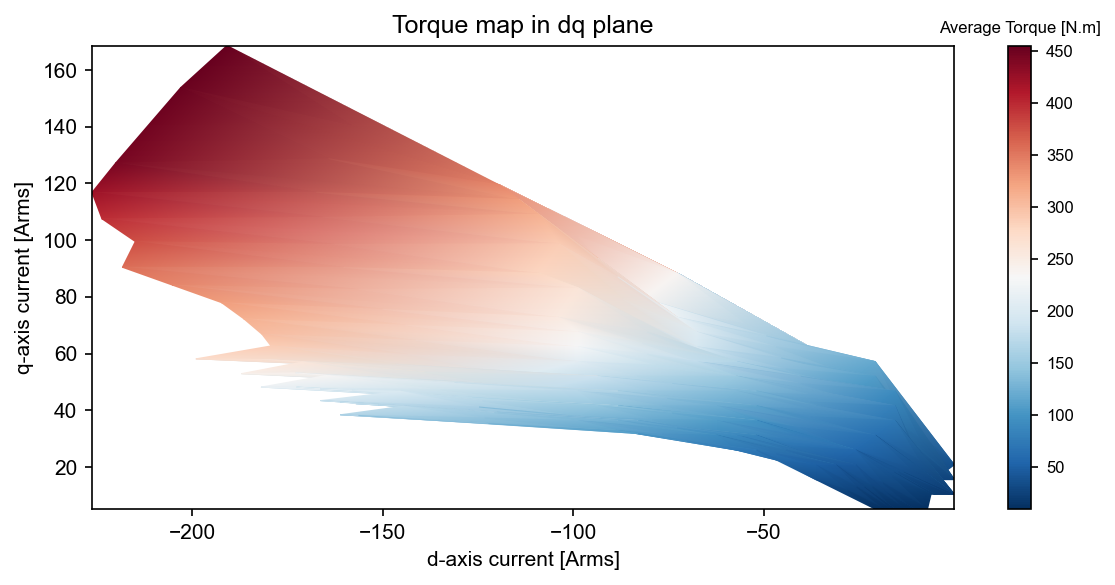

In [30]:
# Init plot map
dict_map = {
    "Xdata": I_MTPA[:, :, 0],  # Id
    "Ydata": I_MTPA[:, :, 1],  # Iq
    "xlabel": "d-axis current [Arms]",
    "ylabel": "q-axis current [Arms]",
    "type_plot": "pcolormesh",
    "is_contour": True,
}

# Plot torque maps
plot_3D(
    Zdata=OP_matrix_MTPA[:, :, 3],
    zlabel="Average Torque [N.m]",
    title="Torque map in dq plane",
    **dict_map,
)